In [ ]:
# Import Libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import plotly.graph_objects as go

In [ ]:
# 1. Data Download and Initial Visualization
data = pd.DataFrame(yf.download("ARTO.JK", start="2020-08-01", end="2024-08-01"))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
# Feature Selection
selected_feature = 'Close'
data = data[[selected_feature]]

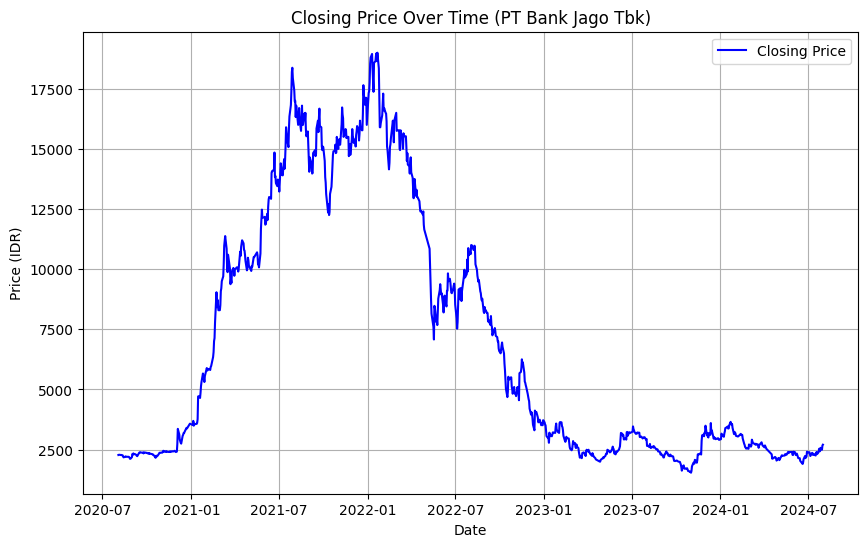

In [ ]:
# Plot the closing price over time
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Close'], label='Closing Price', color='blue')
plt.title('Closing Price Over Time (PT Bank Jago Tbk)')
plt.xlabel('Date')
plt.ylabel('Price (IDR)')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
data.isnull().sum()

,,0
Price,Ticker,
Close,ARTO.JK,0


In [ ]:
# 2. Feature Scaling and Splitting

# Normalize the closing prices using Min-Max Scaling
scaler_input = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler_input.fit_transform(data['Close'].values.reshape(-1, 1))
data['Scaled_Close'] = scaled_data

In [ ]:
# First 3 rows
print("First 3 rows:")
print(data[['Close', 'Scaled_Close']].head(3))

# Last 3 rows
print("\nLast 3 rows:")
print(data[['Close', 'Scaled_Close']].tail(3))

First 3 rows:
Price             Close Scaled_Close
Ticker          ARTO.JK             
Date                                
2020-08-03  2272.359619     0.042219
2020-08-04  2280.653076     0.042694
2020-08-05  2280.653076     0.042694

Last 3 rows:
Price        Close Scaled_Close
Ticker     ARTO.JK             
Date                           
2024-07-29  2490.0     0.054681
2024-07-30  2670.0     0.064987
2024-07-31  2700.0     0.066705


In [ ]:
# Split the data into training, testing, and validation set (70% train, 15% test, 15% validation)
train_size = int(len(scaled_data) * 0.7)  # 70% training
val_size = int(len(scaled_data) * 0.15)   # 15% validation

In [ ]:
# Split the data
train_data = scaled_data[:train_size]
val_data = scaled_data[train_size:train_size + val_size]
test_data = scaled_data[train_size + val_size:]

print(f"Training Data Size: {len(train_data)}, Testing Data Size: {len(test_data)}, Validation Data Size: {len(val_data)}")

Training Data Size: 674, Testing Data Size: 146, Validation Data Size: 144


In [ ]:
# Prepare outputs
train_output = scaled_data[:train_size]
val_output = scaled_data[train_size:train_size + val_size]
test_output = scaled_data[train_size + val_size:]

In [ ]:
# Function to prepare sequences
def prepare_data(data, output, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps), 0])
        y.append(output[i + n_steps, 0])
    return np.array(X), np.array(y)

In [ ]:
# Sequence length
n_steps = 60
X_train, y_train = prepare_data(train_data, train_output, n_steps)
X_val, y_val = prepare_data(val_data, val_output, n_steps)
X_test, y_test = prepare_data(test_data, test_output, n_steps)

In [ ]:
# Reshape for GRU
X_train = X_train.reshape((X_train.shape[0], n_steps, 1))
X_val = X_val.reshape((X_val.shape[0], n_steps, 1))
X_test = X_test.reshape((X_test.shape[0], n_steps, 1))

In [ ]:
# 3. GRU Model Construction and Training

# Function to build the GRU model
def build_gru_model(input_shape):
    model = Sequential([
        GRU(units=128, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        GRU(units=64, return_sequences=True),
        Dropout(0.3),
        GRU(units=32),
        Dense(units=1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

In [ ]:
# Build and compile the GRU model
gru_model = build_gru_model((n_steps, 1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

In [ ]:
# Train the model
history = gru_model.fit(
    X_train, y_train,
    epochs=200, batch_size=32,
    validation_data=(X_val, y_val),
    verbose=2, callbacks=[early_stopping]
)

Epoch 1/200
20/20 - 16s - 821ms/step - loss: 0.0434 - val_loss: 0.0039
Epoch 2/200
20/20 - 4s - 207ms/step - loss: 0.0058 - val_loss: 1.7881e-04
Epoch 3/200
20/20 - 6s - 288ms/step - loss: 0.0035 - val_loss: 1.5203e-04
Epoch 4/200
20/20 - 3s - 148ms/step - loss: 0.0036 - val_loss: 1.9143e-04
Epoch 5/200
20/20 - 5s - 253ms/step - loss: 0.0034 - val_loss: 1.5948e-04
Epoch 6/200
20/20 - 5s - 253ms/step - loss: 0.0026 - val_loss: 1.4336e-04
Epoch 7/200
20/20 - 5s - 256ms/step - loss: 0.0026 - val_loss: 1.4853e-04
Epoch 8/200
20/20 - 4s - 178ms/step - loss: 0.0027 - val_loss: 1.3575e-04
Epoch 9/200
20/20 - 4s - 223ms/step - loss: 0.0025 - val_loss: 1.3230e-04
Epoch 10/200
20/20 - 5s - 254ms/step - loss: 0.0026 - val_loss: 2.2217e-04
Epoch 11/200
20/20 - 6s - 302ms/step - loss: 0.0022 - val_loss: 1.2844e-04
Epoch 12/200
20/20 - 4s - 210ms/step - loss: 0.0023 - val_loss: 1.2103e-04
Epoch 13/200
20/20 - 3s - 149ms/step - loss: 0.0023 - val_loss: 1.2392e-04
Epoch 14/200
20/20 - 6s - 287ms/step 

In [ ]:
gru_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 60, 128)             │          50,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 60, 64)              │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 290,981 (1.11 MB)

 Trainable params: 96,993 (378.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 193,988 (757.77 KB)

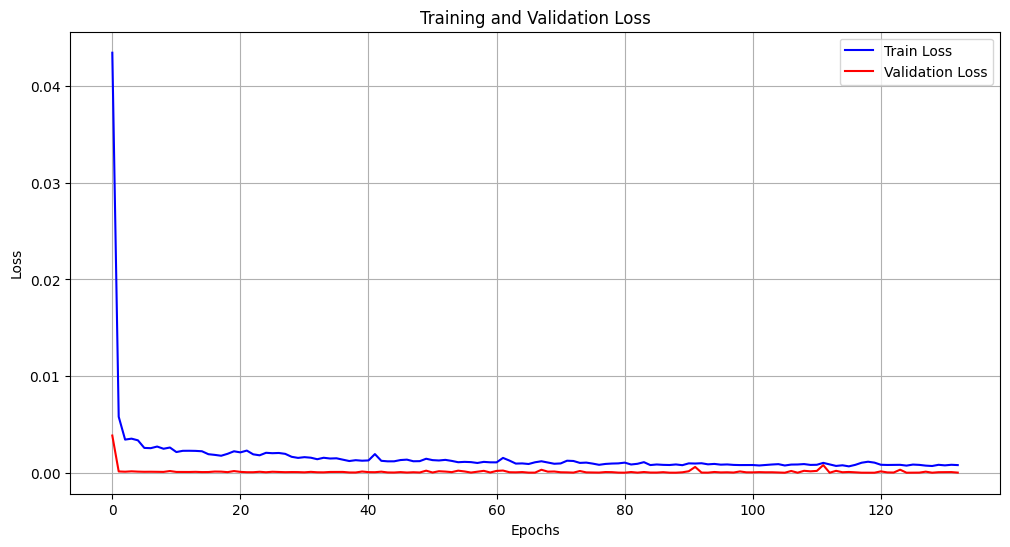

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# 4. Model Evaluation and Visualization

# Evaluate Training Performance
train_pred = gru_model.predict(X_train)
train_pred_inv = scaler_input.inverse_transform(train_pred)
y_train_inv = scaler_input.inverse_transform(y_train.reshape(-1, 1))

train_mse = mean_squared_error(y_train_inv, train_pred_inv)
train_rmse = math.sqrt(train_mse)
train_mape = np.mean(np.abs((y_train_inv - train_pred_inv) / y_train_inv)) * 100

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step


In [ ]:
# Evaluate Validation Performance
val_pred = gru_model.predict(X_val)
val_pred_inv = scaler_input.inverse_transform(val_pred)
y_val_inv = scaler_input.inverse_transform(y_val.reshape(-1, 1))

val_mse = mean_squared_error(y_val_inv, val_pred_inv)
val_rmse = math.sqrt(val_mse)
val_mape = np.mean(np.abs((y_val_inv - val_pred_inv) / y_val_inv)) * 100

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [ ]:
# Evaluate Test Performance
y_test_inv = scaler_input.inverse_transform(y_test.reshape(-1, 1))  # Actual test values
y_pred_inv = scaler_input.inverse_transform(gru_model.predict(X_test))  # Predicted values

test_mse = mean_squared_error(y_test_inv, y_pred_inv)
test_rmse = math.sqrt(test_mse)
test_mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


In [ ]:
# Plot predictions vs actual prices
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=data.index[train_size + val_size + n_steps:],
    y=y_test_inv.flatten(),
    mode='lines',
    name='Actual Prices',
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=data.index[train_size + val_size + n_steps:],
    y=y_pred_inv.flatten(),
    mode='lines',
    name='Predicted Prices',
    line=dict(color='red')
))
fig.update_layout(
    title="Stock Price Prediction (GRU)",
    xaxis_title="Date", yaxis_title="Price (IDR)"
)
fig.show()

In [ ]:
# Display Results
print("\nPerformance Metrics:")
print(f"{'Dataset':<12} {'MSE':<10} {'RMSE':<10} {'MAPE (%)':<10}")
print(f"{'-'*40}")
print(f"{'Training':<12} {train_mse:<10.4f} {train_rmse:<10.4f} {train_mape:<10.2f}")
print(f"{'Validation':<12} {val_mse:<10.4f} {val_rmse:<10.4f} {val_mape:<10.2f}")
print(f"{'Test':<12} {test_mse:<10.4f} {test_rmse:<10.4f} {test_mape:<10.2f}")


Performance Metrics:
Dataset      MSE        RMSE       MAPE (%)  
----------------------------------------
Training     162490.6850 403.1013   3.24      
Validation   17765.4427 133.2871   3.75      
Test         10252.0146 101.2522   3.45      
